# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Необходимо построить модель, которая умеет её определять. Есть данные о технических характеристиках, комплектации и ценах других автомобилей.

**Критерии, которые важны:**

- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Условия:**

- Не ограничиваться градиентным бустингом
- Для оценки качества моделей применять метрику RMSE. RMSE должно быть меньше 2500.
- Освоить библиотеку LightGBM и её средствами построить модели градиентного бустинга.
- Ввести время выполнения ячейки кода
- В модели градиентного бустинга можно изменять только два-три параметра.

**План исследования:**

- Обзор данных
- Предобработка данных
- Обучение моделей
- Выбор лучшей модели и ее тестирование
- Вывод

## Подготовка данных

Загружаю необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool, cv
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

STATE = 12345

In [2]:
try:
    data = pd.read_csv('C:/Users/School252/Downloads/autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [3]:
display(data[:5])
print('-----------------------------------------------------------------')

display(data.info())
print('-----------------------------------------------------------------')

display(data.describe())
print('-----------------------------------------------------------------')

print('Кол-во пропусков:')
display(data.isna().sum())
print('-----------------------------------------------------------------')

print('Кол-во дубликатов -', data.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  La

None

-----------------------------------------------------------------


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


-----------------------------------------------------------------
Кол-во пропусков:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

-----------------------------------------------------------------
Кол-во дубликатов - 4


1. Есть признаки, которые никак не влияют на цену - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen. От них надо избавиться
2. В признаках, влияющих на цену, есть пропуски
3. В целевом признаке и признаке Power есть 0, наверняка есть другие выбросы
4. В RegistrationYear указан минимальный год 1000, наверняка есть другие выбросы
5. Есть дубликаты, от которых также надо избавиться
6. В названиях признаков надо избавиться от верблюжьего стиля
7. В признаках Gearbox и NotRepaired значения можно заменить на 1 и 0

## Предобработка данных

In [4]:
# Змеиный стиль
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [5]:
# Дубликаты
data.drop_duplicates(inplace=True)  

In [6]:
#избавляюсь от признаков, не влияющих на целевой признак:
data.drop(columns=['date_crawled', 'date_created', 'number_of_pictures',
                    'postal_code', 'last_seen', 'registration_month'],
           axis=1,
           inplace=True)

### Признак price

In [7]:
# Нулевые значения
data['price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64

In [8]:
# Избавимся от нулевых значений
data = data.query('price > 0')

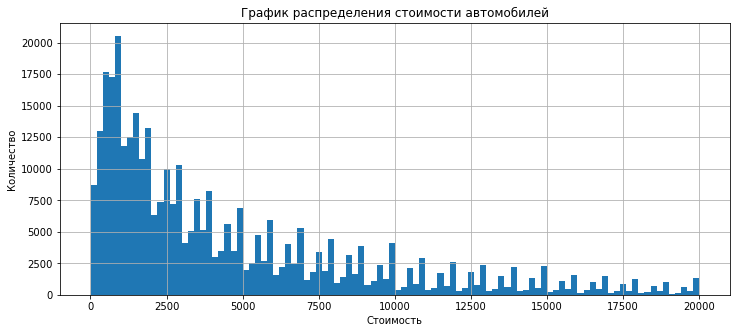

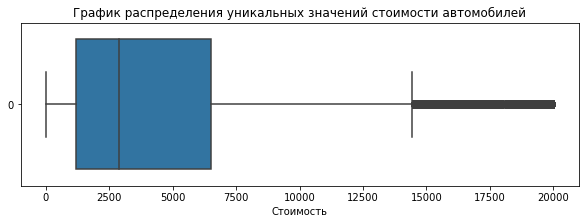

In [9]:
# Гистограмма и ящик с усами
data['price'].hist(bins=100, figsize=(12,5))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость')
plt.ylabel('Количество')

plt.figure(figsize=(10,3))
sns.boxplot(data=data['price'], orient='h')
plt.title('График распределения уникальных значений стоимости автомобилей')
plt.xlabel('Стоимость')
plt.show()

In [10]:
# Из-за того что длинный хвост у 15000, посмотрим квантили
data['price'].quantile([.05, .95])

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

In [11]:
#избавляюсь от 10% строк, где цена меньше 350 и больше 14800:
data = data.query('350 <= price <= 14800')

### Признак registration_year

In [12]:
data['registration_year'].value_counts()

2000    20907
2005    20811
1999    20621
2003    19217
2001    19091
        ...  
4800        1
2290        1
1930        1
1001        1
1946        1
Name: registration_year, Length: 130, dtype: int64

In [13]:
data['registration_year'].unique()

array([1993, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2007, 2009,
       2002, 2018, 1997, 1990, 2017, 1981, 2003, 2016, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1994, 1996, 1989, 2011, 1985,
       1982, 1976, 1973, 2015, 1969, 1971, 1987, 1983, 1988, 1980, 1970,
       1986, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1958, 1967, 3200, 1960, 1941, 9999,
       8888, 1500, 4100, 1962, 1929, 1957, 2066, 1949, 1940, 2019, 1937,
       1951, 1800, 1959, 1954, 1234, 5300, 9000, 2900, 6000, 1953, 5911,
       1000, 1400, 5000, 4000, 1952, 8500, 1950, 3700, 3800, 4800, 1942,
       7000, 1956, 1935, 1936, 1923, 2290, 1930, 1001, 9450, 1944, 2500,
       1938, 1934, 1943, 1928, 5555, 1600, 1111, 1932, 1039, 3000, 2800,
       1931, 1948, 4500, 1602, 7800, 7100, 1300, 8200, 1946], dtype=int64)

In [14]:
data = data.query('1975 <= registration_year <= 2016')

### Признак power

In [15]:
data['power'].value_counts()

0       26795
75      20640
60      13045
150     13008
101     12106
        ...  
2789        1
2461        1
6006        1
6018        1
1548        1
Name: power, Length: 627, dtype: int64

In [16]:
data.power.describe()

count    296131.000000
mean        111.028275
std         184.505329
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64

In [17]:
# Убираем значения больше 1600
data = data.query('power >= 10 & power <= 1600')

In [18]:
data.isna().sum()

price                    0
vehicle_type          9205
registration_year        0
gearbox               4684
power                    0
model                 9543
kilometer                0
fuel_type            13455
brand                    0
repaired             38209
dtype: int64

### Признак kilometr

In [19]:
data['kilometer'].value_counts()

150000    183627
125000     29148
100000     11366
90000       9039
80000       7752
70000       6539
60000       5584
50000       4453
40000       3436
30000       2905
20000       2331
5000        2249
10000        580
Name: kilometer, dtype: int64

### Признак brand

In [20]:
data.brand. value_counts()

volkswagen        58354
opel              29854
bmw               28889
mercedes_benz     24458
audi              22560
ford              18500
renault           12928
peugeot            8945
fiat               7018
seat               5413
skoda              4583
smart              4449
mazda              4446
citroen            4006
toyota             3855
nissan             3602
hyundai            2887
volvo              2564
mini               2491
mitsubishi         2286
honda              2270
kia                1912
suzuki             1848
alfa_romeo         1846
chevrolet          1347
sonstige_autos     1224
chrysler           1093
dacia               785
subaru              571
daihatsu            557
jeep                494
saab                444
porsche             390
jaguar              372
daewoo              366
land_rover          362
lancia              340
rover               327
trabant             222
lada                151
Name: brand, dtype: int64

### Признак gearbox

In [21]:
#заменяю NaN на 'manual':
data.fillna({'gearbox':'manual'}, inplace=True)

In [22]:
data.dropna(subset=['gearbox'], inplace=True)

### Признак model

In [23]:
#заменяю NaN на 'unknown':
data.fillna({'model':'unknown'}, inplace=True)
data.model.value_counts()

golf                  22613
other                 17961
3er                   16108
polo                   9730
unknown                9543
                      ...  
serie_2                   2
range_rover_evoque        2
gl                        2
serie_3                   1
rangerover                1
Name: model, Length: 250, dtype: int64

### Признак vehicletype

In [24]:
#заменяю пропуски на unknown:
data.fillna({'vehicle_type':'unknown'}, inplace=True)
data.vehicle_type.value_counts()

sedan          76356
small          64638
wagon          54745
bus            24453
convertible    16423
coupe          12311
unknown         9205
suv             8687
other           2191
Name: vehicle_type, dtype: int64

### Признак fueltype

In [25]:
data.fillna({'fuel_type':'unknown'}, inplace=True)
data.fuel_type.value_counts()

petrol      171649
gasoline     78636
unknown      13455
lpg           4527
cng            467
hybrid         154
other           66
electric        55
Name: fuel_type, dtype: int64

### Переменная reparied

In [26]:
#заменяю NaN на 'yes', так как обычно любая подержанная машина была в ремонте:
data.fillna({'repaired':'yes'}, inplace=True)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269009 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              269009 non-null  int64 
 1   vehicle_type       269009 non-null  object
 2   registration_year  269009 non-null  int64 
 3   gearbox            269009 non-null  object
 4   power              269009 non-null  int64 
 5   model              269009 non-null  object
 6   kilometer          269009 non-null  int64 
 7   fuel_type          269009 non-null  object
 8   brand              269009 non-null  object
 9   repaired           269009 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.6+ MB


In [28]:
data.describe()

,price,registration_year,power,kilometer
count,269009.000000,269009.000000,269009.000000,269009.000000
mean,4272.996212,2002.767116,119.014658,130335.769435
std,3590.559251,5.845879,56.000901,34822.534459
min,350.000000,1975.000000,10.000000,5000.000000
25%,1400.000000,1999.000000,76.000000,125000.000000
50%,3000.000000,2003.000000,110.000000,150000.000000
75%,6300.000000,2007.000000,144.000000,150000.000000
max,14800.000000,2016.000000,1600.000000,150000.000000


In [29]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,price,registration_year,power,kilometer
price,1.000000,0.530673,0.406938,-0.338242
registration_year,0.530673,1.000000,0.068517,-0.309371
power,0.406938,0.068517,1.000000,0.143916
kilometer,-0.338242,-0.309371,0.143916,1.000000


### Вывод 1

**Избавился от:**
- признаков, которые никак не влияют на целевой признак
- верблюжьего стиля
- дубликатов
- выбросов в целевом признаке и признаках

**Заполнил пропуски в:**
- gearbox значением 'manual'
- repaired значением 'yes'
- model, vehicletype, fueltype значением 'unknown'

**В целом цена логично зависит:**
- прямо пропорционально от года регистрации, мощности
- обратно пропорционально от пробега, ремонта, типа коробки

## Обучение моделей

In [30]:
features = data.drop(['price'],axis=1)
target = data['price']

In [31]:
category_features = ['vehicle_type', 'gearbox', 'brand', 'model', 'fuel_type', 'repaired']
number_features = ['registration_year', 'power', 'kilometer']

In [32]:
features_ohe = pd.get_dummies(features, columns=category_features, drop_first=True)
features_ohe.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,repaired_yes
2,2004,163,125000,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,2001,75,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2008,69,90000,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
5,1995,102,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
6,2004,109,150000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [33]:
features_train, features_test, target_train, target_test = train_test_split(features_ohe,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=STATE)

In [34]:
scaler = StandardScaler()

scaler.fit(features_train[number_features])
features_train_scaled = features_train.copy()
features_train_scaled[number_features] = scaler.transform(features_train[number_features])
features_train_scaled.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,repaired_yes
31272,1.067787,0.374994,0.563063,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
123912,0.554174,-0.693813,-0.155939,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1735,0.382969,-0.978828,0.563063,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
342077,-0.644258,0.553128,0.563063,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
87847,-0.644258,-0.319731,0.563063,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

In [36]:
import time

class ModelHelper:
    def __init__(self, name, model):
        """Constructor"""
        self.name = name
        self.model = model
    
    def fit(self, features, target):
        start = time.time()    
        self.model.fit(features, target)
        end = time.time() - start
        self.fitTime = end
    
    def predict(self, features, grid):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = (grid.best_score_ * -1)**0.5
        
    def prediction(self, features, target):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = rmse(target, predicted)
        
    def getResult(self):
        return self.name, self.fitTime, self.predictedTime, self.rmse

In [37]:
result = []

In [38]:
def print_result(result):
    print('|{: >20}|{: >18}|{: >18}|{: >12}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for info in result:
        print('|{: >20}|{: >18.5f}|{: >18.5f}|{: >12.5f}|'.format(info[0], info[1], info[2], info[3]))

Из даных убраны лишние и "битые" значения, текстовые признаки трансформированы в цифровой формат, а так же выборки разделены на тренировочную и тестовую для проверки качества предсказания моделей. Теперь перейдём к обучению моделей и выбору лучшей. А так же оценим их качество предсказания и скорость обучения.

### Модель Random Forest

In [39]:
%%time

parameters = {'n_estimators': range(5,11,5),'max_depth': range(1,8,3), 'min_samples_leaf': range(1,5,2), 'min_samples_split': range(2,6,2)}

model = RandomForestRegressor()
grid = GridSearchCV(model, parameters, cv=3, scoring='neg_mean_squared_error')
grid.fit(features_train_scaled, target_train)

grid.best_params_

CPU times: total: 21min 59s
Wall time: 22min 5s


{'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 10}

In [40]:
model_forest = grid.best_estimator_
model_forest_helper = ModelHelper('Random forest', model_forest)
model_forest_helper.fit(features_train_scaled, target_train)
model_forest_helper.predict(features_train_scaled, grid)
result.append(model_forest_helper.getResult())

### Модель CatBoostRegressor

In [41]:
features_train_b, features_test_b, target_train_b, target_test_b = train_test_split(features,
                                                                                    target,
                                                                                    test_size=.25,
                                                                                    random_state=STATE)

In [42]:
scaler = StandardScaler()
scaler.fit(features_train_b[number_features])
features_train_b[number_features] = scaler.transform(features_train_b[number_features])
features_test_b[number_features] = scaler.transform(features_test_b[number_features])

features_train_b.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
31272,wagon,1.067787,manual,0.374994,mondeo,0.563063,gasoline,ford,no
123912,small,0.554174,manual,-0.693813,corsa,-0.155939,petrol,opel,yes
1735,small,0.382969,manual,-0.978828,polo,0.563063,petrol,volkswagen,no
342077,wagon,-0.644258,manual,0.553128,passat,0.563063,lpg,volkswagen,no
87847,sedan,-0.644258,manual,-0.319731,focus,0.563063,petrol,ford,no


In [43]:
for col in category_features:
    features_train_b[col] = features_train_b[col].astype('category')

In [44]:
for col in category_features:
    features_test_b[col] = features_test_b[col].astype('category')

In [45]:
features_train_b.dtypes

vehicle_type         category
registration_year     float64
gearbox              category
power                 float64
model                category
kilometer             float64
fuel_type            category
brand                category
repaired             category
dtype: object

In [46]:
cbr = CatBoostRegressor(loss_function='RMSE', silent=True, random_seed=STATE, cat_features=category_features)
cbr_params = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 60, 20),'depth': range(5,10,2)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=3, scoring='neg_mean_squared_error')
grid_cbr.fit(features_train_b, target_train_b);

grid_cbr.best_params_
#  Для отладки: {'depth': 9, 'iterations': 40, 'learning_rate': 1.0}

{'depth': 9, 'iterations': 40, 'learning_rate': 1.0}

In [47]:
model_cbr = grid_cbr.best_estimator_
model_cbr_helper = ModelHelper('CatBoost', model_cbr)
model_cbr_helper.fit(features_train_b, target_train_b)
model_cbr_helper.predict(features_train_b, grid_cbr)
result.append(model_cbr_helper.getResult())

In [48]:
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|          61.32017|           1.06016|  1739.87605|
|            CatBoost|           7.89432|           0.26468|  1402.27024|


### LightGBM

In [49]:
%%time

gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=STATE, categorical_column=category_features)
gbm_params = {'learning_rate': np.logspace(-3, 0, 5), 'n_estimators': range(20, 61, 20), 'num_leaves': range(20, 41, 10)}

grid_gbm = GridSearchCV(gbm, gbm_params, cv=3, scoring='neg_mean_squared_error')
grid_gbm.fit(features_train_b, target_train_b);

grid_gbm.best_params_
# Для отладки - {'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 41}

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010408 seconds.
You can set `force_row_wise=true` to remo

{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 40}

In [50]:
# Посмотрим, что получилось в итоге
model_gbm = grid_gbm.best_estimator_
model_gbm_helper = ModelHelper('LightGBM', model_gbm)
model_gbm_helper.fit(features_train_b, target_train_b)
model_gbm_helper.predict(features_train_b, grid_gbm)
result.append(model_gbm_helper.getResult())

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021567 seconds.
You can set `force_col_wise=true` to remove the overhead.


### Вывод 3

После обучения 3 моделей все значения RMSE оказались < 2500. В ходе анализа найдем наилучшую модель

## Анализ моделей

In [51]:
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|          61.32017|           1.06016|  1739.87605|
|            CatBoost|           7.89432|           0.26468|  1402.27024|
|            LightGBM|           1.39457|           0.73384|  1343.55198|


Выбираю модель LGBM, потому что у неелучший показатель RMSE, выше скорость обучения и выше скорость предсказания

In [52]:
# Оцениваю на тестовой выборке
model_gbm = grid_gbm.best_estimator_
model_gbm_helper = ModelHelper('LightGBM', model_gbm)
model_gbm_helper.fit(features_train_b, target_train_b)
model_gbm_helper.prediction(features_test_b, target_test_b)
result.append(model_gbm_helper.getResult())

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021034 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [53]:
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|          61.32017|           1.06016|  1739.87605|
|            CatBoost|           7.89432|           0.26468|  1402.27024|
|            LightGBM|           1.39457|           0.73384|  1343.55198|
|            LightGBM|           1.37226|           0.31093|  1346.16000|


In [54]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train_b, target_train_b)
dummy_pred = dummy_regr.predict(features_test_b)
rmse(target_test_b, dummy_pred)

3606.09

### Вывод 4

- загрузил данные и провел их предобработку - очистку, заполнение, удаление лишних данных
- сравнил 3 модели с разными гиперпараметрами
- выбрал лучшую модель по 3 показателям - RMSE, время обучения и время предскзания - и проверил ее на тестовой выборке
- LGBM показала себя лушей по всем параметрам, RMSE = 1346